### 解壓縮檔案

In [1]:
import os
import cv2
import zipfile
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit

zip_name = "EmotionDetector.zip"
file_dir = "EmotionDetector"

if not os.path.exists(os.getcwd()+'\\'+file_dir):
    with zipfile.ZipFile(zip_name, 'r') as myzip:
        for file in myzip.namelist():
                myzip.extract(file, file_dir)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_path = os.getcwd()+'\\EmotionDetector\\train.csv'
test_path = os.getcwd()+'\\EmotionDetector\\test.csv'


train_set = pd.read_csv(train_path, encoding='big5')
test_set = pd.read_csv(test_path, encoding='big5')
train_set.sample(5) #隨機取其中5筆資料

,Emotion,Pixels
547,6,42 64 73 83 99 89 75 83 94 92 93 106 113 123 1...
1148,5,21 17 8 3 2 2 9 17 23 22 23 28 29 31 41 56 72 ...
369,6,226 237 252 255 247 190 115 63 53 51 55 54 52 ...
2526,0,76 82 89 99 105 108 108 111 108 109 104 102 10...
2429,6,102 106 111 118 125 130 130 132 136 136 137 13...


In [3]:
print(train_set.shape)
print(test_set.shape)

(4178, 2)
(1312, 1)


## EmotionDetectorUtils

In [4]:
__author__ = 'Charlie'
import pandas as pd
import numpy as np
import os, sys, inspect
from six.moves import cPickle as pickle
import scipy.misc as misc

IMAGE_SIZE = 48
NUM_LABELS = 7
VALIDATION_PERCENT = 0.1  # use 10 percent of training images for validation

IMAGE_LOCATION_NORM = IMAGE_SIZE / 2

np.random.seed(0)

emotion = {0:'anger', 1:'disgust',\
           2:'fear',3:'happy',\
           4:'sad',5:'surprise',6:'neutral'}

def read_data(data_dir, force=False):
    def create_onehot_label(x):
        label = np.zeros((1, NUM_LABELS), dtype=np.float32)
        label[:, int(x)] = 1
        return label

    pickle_file = os.path.join(data_dir, "EmotionDetectorData.pickle")
    if force or not os.path.exists(pickle_file):
        train_filename = os.path.join(data_dir, "train.csv")
        data_frame = pd.read_csv(train_filename)
        data_frame['Pixels'] = data_frame['Pixels'].apply(lambda x: np.fromstring(x, sep=" ") / 255.0) # 用空白分隔每個string
        data_frame = data_frame.dropna()
        print ("Reading train.csv ...")

        train_images = np.vstack(data_frame['Pixels']).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
        print (train_images.shape)
        train_labels = np.array([list(map(create_onehot_label, data_frame['Emotion'].values))]).reshape(-1, NUM_LABELS)
        print (train_labels.shape)

        permutations = np.random.permutation(train_images.shape[0])   # 隨機排列
        train_images = train_images[permutations]
        train_labels = train_labels[permutations]
        validation_percent = int(train_images.shape[0] * VALIDATION_PERCENT)
        validation_images = train_images[:validation_percent]         # 取後面10%
        validation_labels = train_labels[:validation_percent]
        train_images = train_images[validation_percent:]              # 取前面90%
        train_labels = train_labels[validation_percent:]

        print ("Reading test.csv ...")
        test_filename = os.path.join(data_dir, "test.csv")
        data_frame = pd.read_csv(test_filename)
        data_frame['Pixels'] = data_frame['Pixels'].apply(lambda x: np.fromstring(x, sep=" ") / 255.0)
        data_frame = data_frame.dropna()
        test_images = np.vstack(data_frame['Pixels']).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

        with open(pickle_file, "wb") as file:
            try:
                print ('Picking ...')
                save = {
                    "train_images": train_images,
                    "train_labels": train_labels,
                    "validation_images": validation_images,
                    "validation_labels": validation_labels,
                    "test_images": test_images,
                }
                pickle.dump(save, file, pickle.HIGHEST_PROTOCOL)

            except:
                print("Unable to pickle file :/")

    with open(pickle_file, "rb") as file:
        save = pickle.load(file)
        train_images = save["train_images"]
        train_labels = save["train_labels"]
        validation_images = save["validation_images"]
        validation_labels = save["validation_labels"]
        test_images = save["test_images"]

    return train_images, train_labels, validation_images, validation_labels, test_images

In [5]:
train_dir = os.getcwd()+'\\EmotionDetector'
train_images, train_labels, validation_images, validation_labels, test_images = read_data(train_dir)

In [6]:
print(train_images.shape)
print(train_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)
print(test_images.shape)

(3761, 48, 48, 1)
(3761, 7)
(417, 48, 48, 1)
(417, 7)
(1312, 48, 48, 1)


### 查看train_images圖片

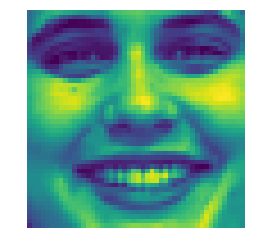

In [7]:
fig = plt.figure(figsize=(4,4)); plt.axis('off')
plt.imshow(train_images[0,:,:,0]); plt.show()

# 建立CNN模型

### Simulation Constants

In [8]:
LABELS = 7     # Number of different types of labels (0-7)
WIDTH = 48      # width / height of the image
CHANNELS = 1    # Number of colors in the image (greyscale)

VALID = len(validation_images)   # Validation data size

STEPS = 5000    # Number of steps to run
BATCH = 100     # Stochastic Gradient Descent batch size
PATCH = 5       # Convolutional Kernel size (濾鏡的大小)
PATCH2 = 3
DEPTH = 16       # Convolutional Kernel depth size == Number of Convolutional Kernels (幾層convelution後的層數)
HIDDEN = 256    #1024 # Number of hidden neurons in the fully connected layer

LR = 0.001      # Learning rate

### CNN Model

In [9]:
tf_data = tf.placeholder(tf.float32, shape=(None, WIDTH, WIDTH, CHANNELS))
tf_labels = tf.placeholder(tf.float32, shape=(None, LABELS))

# 卷積層1參數(濾鏡大小X影像色彩X特徵個數)
w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
b1 = tf.Variable(tf.zeros([DEPTH]))

# 卷積層2參數(濾鏡大小X影像色彩X特徵個數)
w2 = tf.Variable(tf.truncated_normal([PATCH2, PATCH2, DEPTH, 2*DEPTH], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))

# 隱藏層參數(平坦輸入個數X神經元個數)
w3 = tf.Variable(tf.truncated_normal([WIDTH // 4 * WIDTH // 4 * 2*DEPTH, HIDDEN], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))

# 輸出層參數(神經元個數X輸出)
w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

In [10]:
def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    x = tf.nn.dropout(x, keep_prob=0.8)
    
    # Fully connected layer
    x = tf.reshape(x, (-1, WIDTH // 4 * WIDTH // 4 * 2*DEPTH))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    X = tf.nn.dropout(x, keep_prob=0.8)
    
    return tf.matmul(x, w4) + b4

# Prediction:
tf_pred = tf.nn.softmax(logits(tf_data))

### 訓練方式

In [11]:
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_data), 
                                                                 labels=tf_labels))
tf_acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

#tf_opt = tf.train.GradientDescentOptimizer(LR)
tf_opt = tf.train.AdamOptimizer(LR)
#tf_opt = tf.train.RMSPropOptimizer(LR)

tf_step = tf_opt.minimize(tf_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Train

In [12]:
# Open the session
init = tf.global_variables_initializer()
session = tf.Session()
saver = tf.train.Saver()

session.run(init)

    
# 計算時間
startTime = time()

# Run the session
ss = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss.get_n_splits(train_images, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss.split(train_images,train_labels), start=1):
    fd = {tf_data:train_images[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:validation_images, tf_labels:validation_labels}  
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')
save_path = saver.save(session, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)
    
    
duration = time()-startTime
print("Train Finished takes:", duration)

Step 500 	 Valid. Acc. = 63.788967
Step 1000 	 Valid. Acc. = 73.381294
Step 1500 	 Valid. Acc. = 79.376503
Step 2000 	 Valid. Acc. = 78.657074
Step 2500 	 Valid. Acc. = 81.774582
Step 3000 	 Valid. Acc. = 82.254196
Step 3500 	 Valid. Acc. = 79.856117
Step 4000 	 Valid. Acc. = 79.616310
Step 4500 	 Valid. Acc. = 80.095924
Step 5000 	 Valid. Acc. = 80.095924
Model saved in path: /tmp/model.ckpt
Train Finished takes: 1732.3864982128143


### Visualize the training History

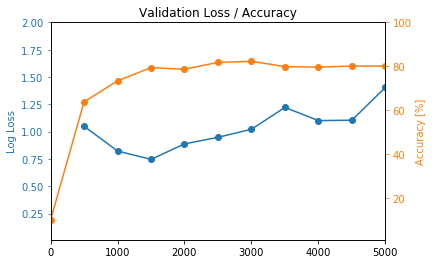

In [13]:
steps, loss, acc = zip(*history)   # 把裡面元素把包成一個個元組

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 2)


ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1,100)
plt.show()


### Results

In [14]:
test_preds = session.run(tf_pred, feed_dict={tf_data:test_images})
test_pred = np.argmax(test_preds, axis=1)   # 取最大值

# Submission
submission = pd.DataFrame(data={'ImageId':(np.arange(test_pred.shape[0])+1), 'Label':test_pred})
submission.to_csv('submission.csv', index=False)
submission.tail()

,ImageId,Label
1307,1308,1
1308,1309,1
1309,1310,3
1310,1311,4
1311,1312,3


### Plot an example

Label Prediction: 5


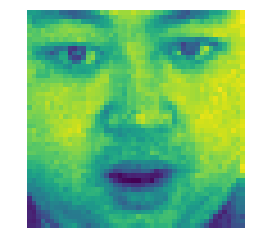

In [15]:
k = 10 # Try different image indices k
print("Label Prediction: %i"%test_pred[k])
fig = plt.figure(figsize=(4,4)); plt.axis('off')
plt.imshow(test_images[k,:,:,0]); plt.show()

### Photo yourself and recognize the motion

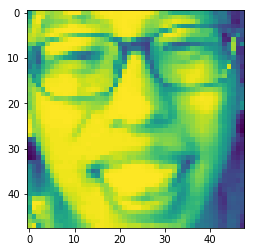

In [16]:
# python字典dict定義每個數字所代表的圖形類別名稱
label_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
#my_img = np.zeros([len(label_dict), WIDTH, WIDTH, 1])
my_labels = []
img_df = pd.DataFrame(columns=['Pixels'])


for i in range(len(label_dict)):
    img = cv2.imread(label_dict[i]+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (WIDTH, WIDTH))
    img = img.reshape(1,-1)
    img_df = img_df.append({'Pixels': img}, ignore_index=True)
    

    
    #img = StandardScaler().fit_transform(np.float32(img))
    #img = img.reshape(WIDTH, WIDTH, 1)
    #my_img[i,:,:,:] = img
    #my_labels.append(i)
img_df['Pixels'] = img_df['Pixels'] / 255.0
my_img = np.vstack(img_df['Pixels']).reshape(-1, WIDTH, WIDTH, 1)    
plt.imshow(my_img[3,:,:,0]); plt.show()

### 預測結果

In [17]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

saver = tf.train.Saver()
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored.")
    my_preds = sess.run(tf_pred, feed_dict={tf_data:my_img})
    my_pred = np.argmax(my_preds, axis=1)   # 取最大值
    print(100*my_preds)
    print(my_pred)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored.
[[99.94 0.00 0.00 0.00 0.06 0.00 0.00]
 [99.93 0.07 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 100.00 0.00 0.00 0.00 0.00]
 [100.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [100.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 32.70 0.00 0.00 67.30 0.00]
 [99.99 0.01 0.00 0.00 0.00 0.00 0.00]]
[0 0 2 0 0 5 0]


In [18]:
def plot_images_labels_prediction(images, labels, prediction, num=7):
    for idx in range(num):
        ax = plt.subplot(2, 4, 1+idx)
        ax.imshow(images[idx,:,:,0])
        
        title = str(idx)+','+label_dict[idx]
        title += '=>'+label_dict[prediction[idx]]
        
        ax.set_title(title, fontsize=8)
        ax.set_xticks([]);ax.set_yticks([])
    plt.show()

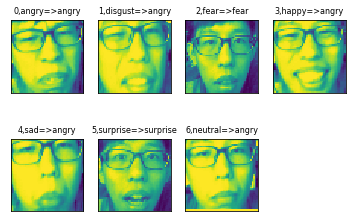

In [19]:
plot_images_labels_prediction(my_img, my_labels, my_pred, 7)

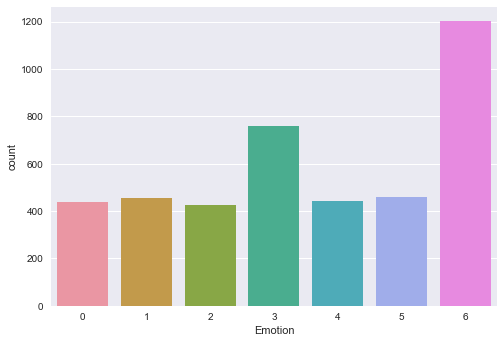

In [20]:
import seaborn as sns
sns.countplot(train_set['Emotion'])